# Directed, Polar Heat Diffusion

In [1]:
import random
import sys
import time

from abc import ABC, abstractmethod
from collections import defaultdict
from dataclasses import dataclass
from itertools import product
from typing import Optional

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

from IPython.display import Markdown
from sklearn.preprocessing import normalize
from tqdm import tqdm_notebook as tqdm

In [2]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8.0, 3.0]

In [3]:
print(time.asctime())

Tue Dec 25 12:52:50 2018


In [4]:
print(sys.version)

3.7.0 (default, Jul 23 2018, 20:22:55) 
[Clang 9.1.0 (clang-902.0.39.2)]


In [5]:
# My favorite seed
np.random.seed(127)
random.seed(127)

In [6]:
def draw(graph):
    edges = graph.edges()
    pos = nx.spring_layout(graph)
    colors = []

    for (u,v,attrib_dict) in list(graph.edges.data()):
        colors.append('blue' if attrib_dict['weight'] == 1 else 'red')

    nx.draw(graph, pos=pos, edges=edges, edge_color=colors, node_size=60)

def assign_bernoulli_polarity(graph, p:float = 0.5) -> None:
    """Bigger probability means more positive edges."""
    for u, v, k in graph.edges(keys=True):
        graph.edges[u, v, k]['weight'] = 1 if random.random() < p else -1

In [7]:
# Insulation parameters to check
alphas = (
    0.1, 
    0.01, 
    0.001, 
)

n_subplots_x = 3
n_subplots_y = int((1 + len(alphas)) / n_subplots_x)
n_subplots_x, n_subplots_y

(3, 1)

# Definitions

Definitions:

Directed graph $G$ is a defined as:

$G = (V, E)$

Where edges $E$ are a subset of pairs of verticies $V$:

$E \subseteq V \times V$

Edges $(V_i, V_j) \in E$ are weighted according to weighting function $w$

$w: V \times V \to \{-1, 0, 1\}$

where edges with positive polarity have weight $w(V_i, V_j) = 1$, negative polarity have weight of $w(V_i, V_j) = -1$, and missing from the graph have $w(V_i, V_j) = 0$. More succinctly, the weights can be represented with weight matrix $W$ defined as

$W_{i,j} = w(V_i, V_j)$

Nodes have initial heats represented as vector $h^0 \in \mathbb{R}^{|V|}$

# Exploration of Update Strategies

## Strategy 1: Update with L1 Norm and Insulation

Heat flows through the out-edges of $V_i$ divided evenly among its neighbors. This first means that $W$ must be row-wise normalized (the "[L1-norm](https://en.wikipedia.org/w/index.php?title=Norm_(mathematics)&section=4#Absolute-value_norm)"). It can be redefined as:

$W_{i,j} = \frac{w(V_i, V_j)}{\sum_{k=0}^{|V|} w(V_i, V_k)}$


Luckily, [`sklearn.preprocessing.normalize`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html) does the trick.

However, only percentage, $\alpha$, of the heat on a given node is allowed to flow at any given step. The remaining percentage of the heat ($1 - \alpha$) stays.

### Derivations and Musings

Heat flows through the *out-edges* of $V_i$ divided evenly among its neighbors.

$\delta_{in}^t(i)  = \sum_{j=1}^{|V|} h_j^t W_{j, i} = h^t W_{., i}$

$\delta_{out}^t(i) = \sum_{j=1}^{|V|} h_i^t W_{i, j}$

$\delta^t(i) = \delta_{in}^t(i) - \delta_{out}^t(i)$

Using step size $\alpha$, the new heat at time point $t + 1$ is

$h^{t+1}_i = (1 - \alpha) h^t_i + \alpha \delta^t(i)$

Therefore

$h^{t+1} = (1 - \alpha) h^t + \alpha \delta^t$

In [8]:
class BaseDiffuser(ABC):
    def __init__(self, graph: nx.DiGraph, alpha: float, steps: Optional[int] = None) -> None:
        self.alpha = alpha
        self.deltas = []
        self.heats = []
        self.steps = steps or int(30 / self.alpha)
        self.weights = self.calculate_weights(graph)

    @staticmethod
    @abstractmethod
    def calculate_weights(graph):
        raise NotImplementedError
    
    @abstractmethod
    def run(self, heat, tqdm_kwargs=None) -> None:
        raise NotImplementedError
    
    def _plot_diffusion_title(self):
        return f'Diffusion ($\\alpha={self.alpha}$)'
    
    def plot(self, heat_plt_kwargs=None, deriv_plt_kwargs=None) -> None:
        fig, (lax, rax) = plt.subplots(1, 2)
        
        lax.set_title(self._plot_diffusion_title())
        lax.set_ylabel('Heat')
        lax.set_xlabel('Time')
        pd.DataFrame(self.heats).plot.line(ax=lax, logx=True, **(heat_plt_kwargs or {}))
    
        rax.set_title('Derivative of Sum of Absolute Heats')
        rax.set_ylabel('Change in Sum of Absolute Heats')
        rax.set_xlabel('Time')
        derivative = [
            (x2 - x1)
            for x1, x2 in zip(self.deltas, self.deltas[1:])
        ]
        pd.DataFrame(derivative).plot.line(ax=rax, logx=True, legend=False, **(deriv_plt_kwargs or {}))
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        return fig, (lax, rax)
        
    @staticmethod
    def optimize_alpha_multirun(graph, alphas, heat):
        alpha_heats = {}
        alpha_deltas = {}
        for alpha in alphas:
            diffuser = Diffuser(graph, alpha)
            diffuser.run(heat)
            alpha_heats[alpha] = diffuser.heats
            alpha_deltas[alpha] = diffuser.deltas
            
        return alpha_deltas, alpha_heats
    
    @classmethod
    def optimize_alpha_multiplot(cls, graph, alphas, heat, heat_plt_kwargs=None, deriv_plt_kwargs=None):
        ds, hs = cls.optimize_alpha_multirun(graph, alphas, heat)
        cls._optimize_alpha_multiplot_helper(hs, plt_kwargs=heat_plt_kwargs)
        cls._optimize_alpha_multiplot_deriv_helper(ds, plt_kwargs=deriv_plt_kwargs)
        
    @staticmethod
    def _optimize_alpha_multiplot_helper(hs, plt_kwargs=None):
        fig, axes = plt.subplots(n_subplots_y, n_subplots_x)
        
        for alpha, ax in zip(alphas, axes.ravel()):
            ax.set_title(f'$\\alpha={alpha}$')
            ax.set_ylabel('Heat')
            ax.set_xlabel('Time')
            pd.DataFrame(hs[alpha]).plot.line(ax=ax, logx=True, **(plt_kwargs or {}))
        
        plt.suptitle(f'Diffusion ($\\alpha={alpha}$)')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    @staticmethod
    def _optimize_alpha_multiplot_deriv_helper(ds, plt_kwargs=None):
        fig, axes = plt.subplots(n_subplots_y, n_subplots_x)
        for alpha, ax in zip(ds, axes.ravel()):
            ax.set_title(f'$\\alpha={alpha}$')
            ax.set_ylabel('Change in Sum of Heats')
            ax.set_xlabel('Time')
            derivative = [
                (x2 - x1)
                for x1, x2 in zip(ds[alpha], ds[alpha][1:])
            ]
            pd.DataFrame(derivative).plot.line(ax=ax, logx=True, legend=False, **(plt_kwargs or {}))

        plt.suptitle('Derivative of Sum of Absolute Heats')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    @classmethod
    def multiplot(cls, graphs_and_heats, alpha):
        for graph, init_h in graphs_and_heats:
            d = cls(graph, alpha=alpha)
            d.run(init_h)
            fig, axes = d.plot(heat_plt_kwargs=dict(legend=False))
            fig.suptitle(graph.name)
            plt.show()


class InsulatedDiffuser(BaseDiffuser):
    def run(self, heat, tqdm_kwargs=None) -> None:
         for _ in tqdm(range(self.steps), leave=False, desc=f'alpha: {self.alpha}'):
            delta = heat @ self.weights
            self.deltas.append(np.sum(np.abs(delta)))
            heat = (1 - self.alpha) * heat + self.alpha * delta
            self.heats.append(heat)


class Diffuser(InsulatedDiffuser):
    @staticmethod
    def calculate_weights(graph):
        adj = nx.to_numpy_array(graph)
        return normalize(adj, norm='l1')

### Example 1

Example 1 is a small system set up to run out of heat defined by the short set of relations

```
A -| B
A -| C
B -> C
```

with weight matrix $W$ (indexed in alphabetical order):

$W=\begin{bmatrix}
    0 & -1 & -1 \\
    0 &  0 &  1 \\
    0 &  0 &  0
\end{bmatrix}$

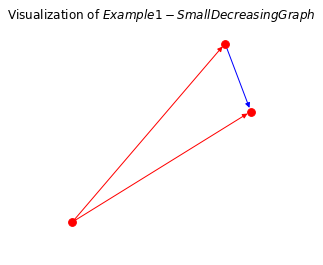

In [9]:
example_1_graph = nx.DiGraph()
example_1_graph.name = 'Example 1 - Small Decreasing Graph'
example_1_graph.add_edges_from([
    ('A', 'B', dict(weight=-1)),
    ('A', 'C', dict(weight=-1)),
    ('B', 'C', dict(weight=+1)),
])

plt.figure(figsize=(3, 3))
draw(example_1_graph)
plt.title(f'Visualization of ${example_1_graph}$')
plt.show()

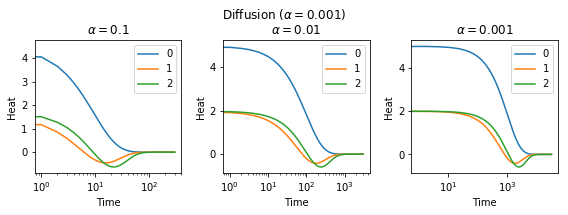

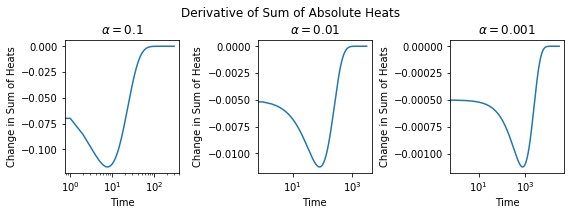

In [10]:
example_1_init_h = np.array([5.0, 2.0, 2.0])
Diffuser.optimize_alpha_multiplot(example_1_graph, alphas, example_1_init_h)

### Example 2

Diffusion on synthetic data.


- **Architecture**: directed scale-free with: 
  - $n=20$
  - $\alpha=0.31$
  - $\beta=0.64$
  - $\gamma=0.05$
- **Polarity**: bernoulli with:
  - $\rho=0.5$
- **Initial Heat**: normal distribution with:
  - $\mu=0$
  - $\sigma=1$

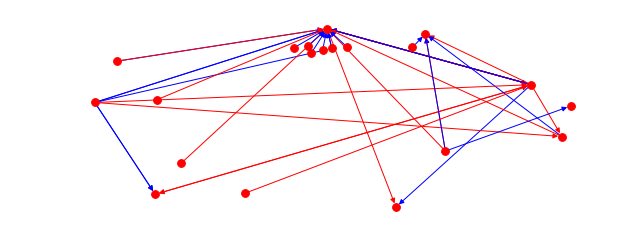

In [11]:
example_2_graph = nx.scale_free_graph(n=20, alpha=.31, beta=.64, gamma=.05)
example_2_graph.name = 'Example 2 - Random Graph with Even Polarity'
assign_bernoulli_polarity(example_2_graph, p=0.5)
draw(example_2_graph)

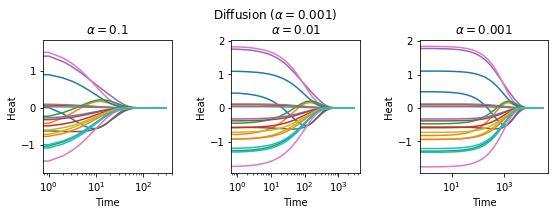

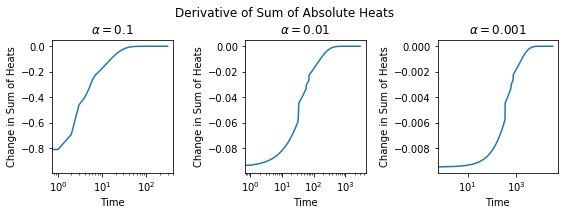

In [12]:
example_2_init_h = np.random.normal(size=example_2_graph.number_of_nodes())
Diffuser.optimize_alpha_multiplot(example_2_graph, alphas, example_2_init_h, heat_plt_kwargs=dict(legend=False))

### Example 3

A random graph with more positive edges.

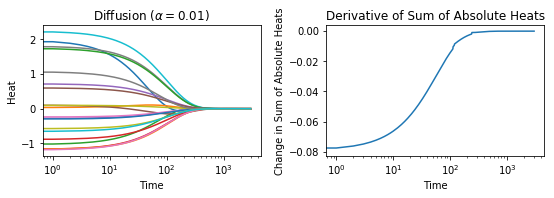

In [13]:
example_3_graph = nx.scale_free_graph(n=20, alpha=.31, beta=.64, gamma=.05)
example_3_graph.name = 'Example 3 - Random Graph with Mostly Negative Polarity'
assign_bernoulli_polarity(example_3_graph, p=0.3)

example_3_init_h = np.random.normal(size=example_3_graph.number_of_nodes())

diffuser = Diffuser(example_3_graph, alpha=0.01)
diffuser.run(example_3_init_h)
diffuser.plot(heat_plt_kwargs=dict(legend=False))
plt.show()

### Example 4

A random graph with more positive edges

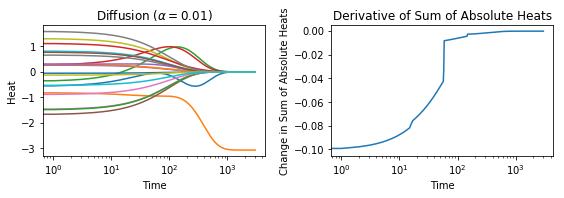

In [14]:
example_4_graph = nx.scale_free_graph(n=20, alpha=.31, beta=.64, gamma=.05)
example_4_graph.name = 'Example 4 - Random Graph with Mostly Positive Polarity'
assign_bernoulli_polarity(example_4_graph, p=0.7)

example_4_init_h = np.random.normal(size=example_4_graph.number_of_nodes())

diffuser = Diffuser(example_4_graph, alpha=0.01)
diffuser.run(example_4_init_h)
diffuser.plot(heat_plt_kwargs=dict(legend=False))
plt.show()

### Example 5

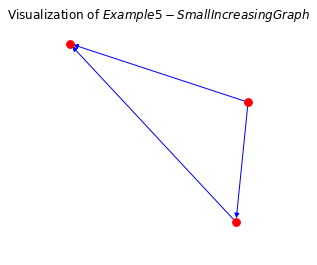

In [15]:
example_5_graph = nx.DiGraph()
example_5_graph.name = 'Example 5 - Small Increasing Graph'
example_5_graph.add_edges_from([
    (0, 1, dict(weight=+1)),
    (0, 2, dict(weight=+1)),
    (1, 2, dict(weight=+1)),
])

plt.figure(figsize=(3, 3))
draw(example_5_graph)
plt.title(f'Visualization of ${example_5_graph}$')
plt.show()

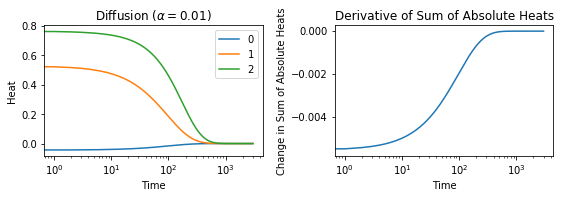

In [16]:
example_5_init_h = np.random.normal(size=example_5_graph.number_of_nodes())

diffuser = Diffuser(example_5_graph, alpha=0.01)
diffuser.run(example_5_init_h)
diffuser.plot()
plt.show()

## Example 6 - Chaotic Increasing System

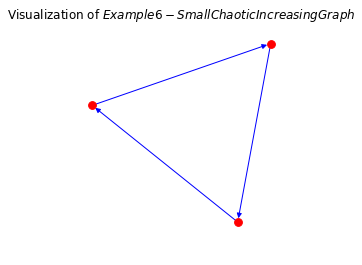

In [17]:
example_6_graph = nx.DiGraph()
example_6_graph.name = 'Example 6 - Small Chaotic Increasing Graph'
example_6_graph.add_edges_from([
    (0, 1, dict(weight=+1)),
    (1, 2, dict(weight=+1)),
    (2, 0, dict(weight=+1)),
])

plt.figure(figsize=(3, 3))
draw(example_6_graph)
plt.title(f'Visualization of ${example_6_graph}$')
plt.show()

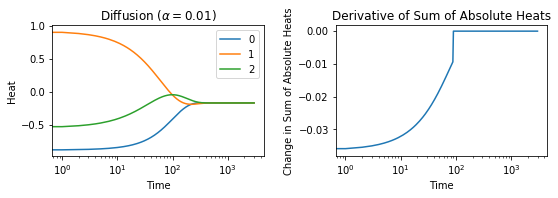

In [18]:
example_6_init_h = np.random.normal(size=example_6_graph.number_of_nodes())

diffuser = Diffuser(example_6_graph, alpha=0.01)
diffuser.run(example_6_init_h)
diffuser.plot()
plt.show()

This is the first example of a system coming to a non-zero steady state! One of the reasons is any system that has a sink will always hemmorage heat out of the sink.

Some ideas on how to deal with this:

1. Scale how much heat that can go into a node based on how much heat it always has (differential equations approach)
2. Self-connect all nodes
3. Self-connect only sink nodes (ones with no out-edges)

In [19]:
example_graphs = [
    (example_1_graph, example_1_init_h),
    (example_2_graph, example_2_init_h),
    (example_3_graph, example_3_init_h),
    (example_4_graph, example_4_init_h),
    (example_5_graph, example_5_init_h),
    (example_6_graph, example_6_init_h),
]

## Strategy 2: Self-connect nodes

All nodes diffuse a bit of heat to themselves, independent of their insulation. This means that the weight matrix gets redefined to have 1's on the diagnal.



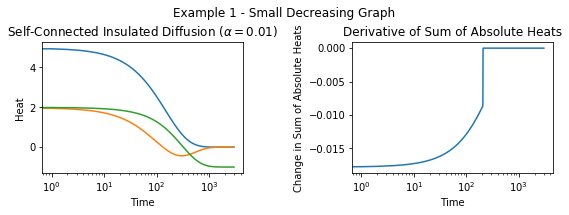

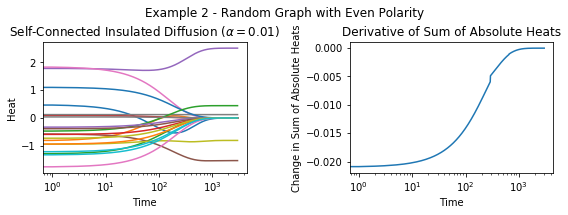

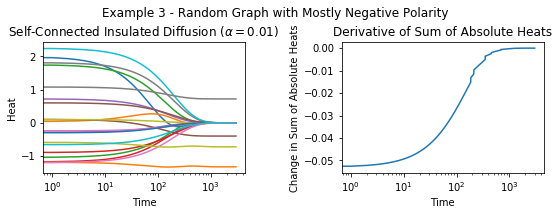

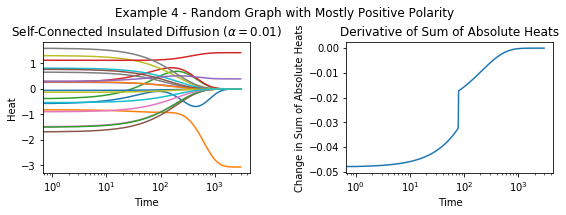

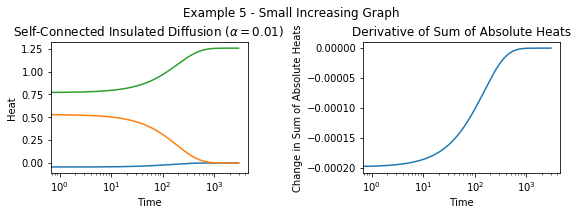

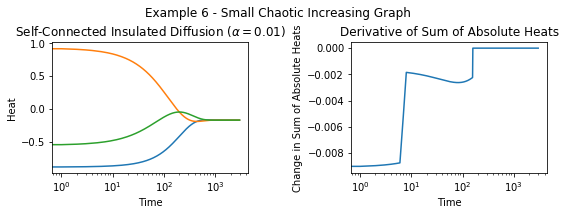

In [20]:
class SelfConnectedInsulatedDiffuser(InsulatedDiffuser):
    """"""
    
    def _plot_diffusion_title(self):
        return f'Self-Connected Insulated Diffusion ($\\alpha={self.alpha}$)'
    
    @staticmethod
    def calculate_weights(graph):
        adj = nx.to_numpy_array(graph)
        for i in range(adj.shape[0]):
            adj[i, i] = 1.0
        return normalize(adj, norm='l1')
    
SelfConnectedInsulatedDiffuser.multiplot(example_graphs, alpha=0.01)

## Strategy 3: Anti-self connectivity

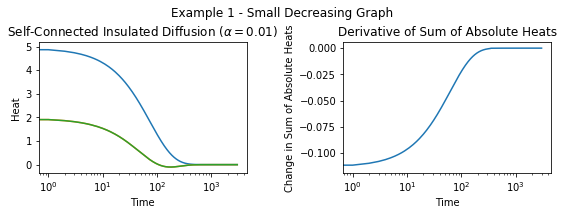

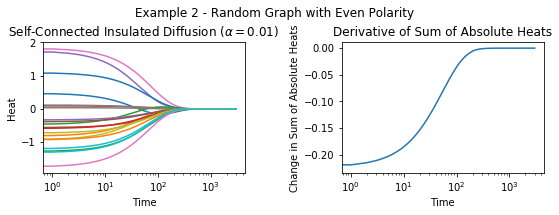

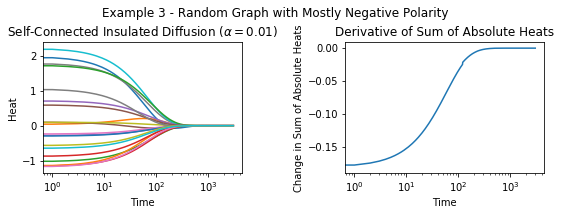

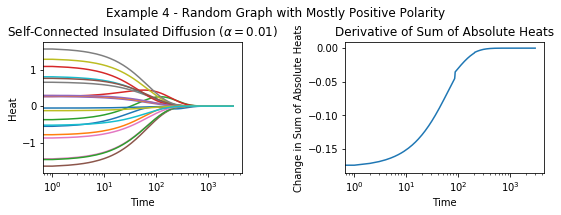

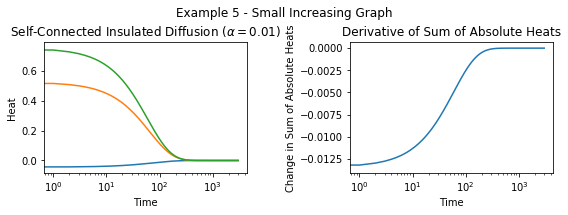

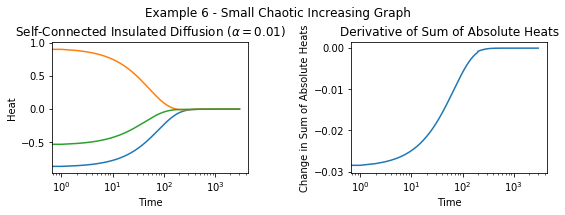

In [21]:
class AntiSelfConnectedInsulatedDiffuser(InsulatedDiffuser):
    """"""
    
    def _plot_diffusion_title(self):
        return f'Self-Connected Insulated Diffusion ($\\alpha={self.alpha}$)'
    
    @staticmethod
    def calculate_weights(graph):
        adj = nx.to_numpy_array(graph)
        for i in range(adj.shape[0]):
            adj[i, i] = -1.0
        return normalize(adj, norm='l1')
    
AntiSelfConnectedInsulatedDiffuser.multiplot(example_graphs, alpha=0.01)